# Predicting Pulsar Stars (group 26 project proposal)

## Introduction

Our group has chosen the Pulsar Star Data as our research dataset. A pulsar is a type of neutron star that emits energy which is detectable through current technology. However, the signals collected may not necessarily identify the presence of a pulsar, as some of the signals can potentially be human-produced radio signals. To determine the legitimacy of these signals, we will work through the pulsar data through a series of classification methods. This [link](https://archive.ics.uci.edu/dataset/372/htru2) is the original source of the dataset. The pulsar data set includes nine columns. The first eight columns contains the following variables:

- Mean of the integrated profile.
- Standard deviation of the integrated profile.
- Excess kurtosis of the integrated profile.
- Skewness of the integrated profile.
- Mean of the DM-SNR curve.
- Standard deviation of the DM-SNR curve.
- Excess kurtosis of the DM-SNR curve.
- Skewness of the DM-SNR curve.

The ninth row is either 0 or 1 (non-pulsar or pulsar).

The question we seek to answer is whether any given new observation is a pulsar or not.

## Preliminary exploratory data analysis

### 1. Loading necessary libraries and initialization

In [1]:
library(tidyverse)
library(tidymodels)
library(reshape2)
install.packages("kknn")

set.seed(2023) # a constant seed to keep the analysis reproducible

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

### 2. Reading data from web

In [2]:
# read the data and assign column names
pulsar_data <- read_csv("https://raw.githubusercontent.com/sinamhdv/DSCI-100-project-group-26/main/HTRU_2.csv", col_names = FALSE)
colnames(pulsar_data) <- c("profile_mean", "profile_stdev", "profile_skewness", "profile_kurtosis", "dm_mean", "dm_stdev", "dm_skewness", "dm_kurtosis", "class")
head(pulsar_data, n = 6)

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


profile_mean,profile_stdev,profile_skewness,profile_kurtosis,dm_mean,dm_stdev,dm_skewness,dm_kurtosis,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


### 3. Cleaning and wrangling data

In [3]:
# change class to factor
pulsar_data <- pulsar_data |>
    mutate(class = as.factor(class))

### 4. Splitting train and test data

In [4]:
# train-test split
pulsar_split <- initial_split(pulsar_data, prop = 0.75, strata = class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)

### 5. Summarizing training data (exploratory data analysis)

We will summarize the data by calculating the mean of every numeric variable for each class, and also counting observations in each class. Then, we will count the number of missing entries in each column, all of which appear to be zero according to the second table below:

In [5]:
# summarize data
pulsar_train |>
    group_by(class) |>
    summarize(class_count = n(), across(profile_mean:dm_kurtosis, mean))

summarize(pulsar_train, across(profile_mean:dm_kurtosis, ~ sum(is.na(.x))))

class,class_count,profile_mean,profile_stdev,profile_skewness,profile_kurtosis,dm_mean,dm_stdev,dm_skewness,dm_kurtosis
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,12195,116.63791,47.35326,0.2093131,0.3776953,8.744286,23.28152,8.847885,112.93407
1,1228,56.88547,38.81569,3.1128235,15.3991441,49.928534,56.14818,2.787913,18.58492


profile_mean,profile_stdev,profile_skewness,profile_kurtosis,dm_mean,dm_stdev,dm_skewness,dm_kurtosis
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0


According to the first table, the number of positive class observations is significantly lower than negative classes. Therefore, we will probably need to balance the data by upsampling to prevent this from affecting our model.

### 6. Visualizing training data (exploratory data analysis)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


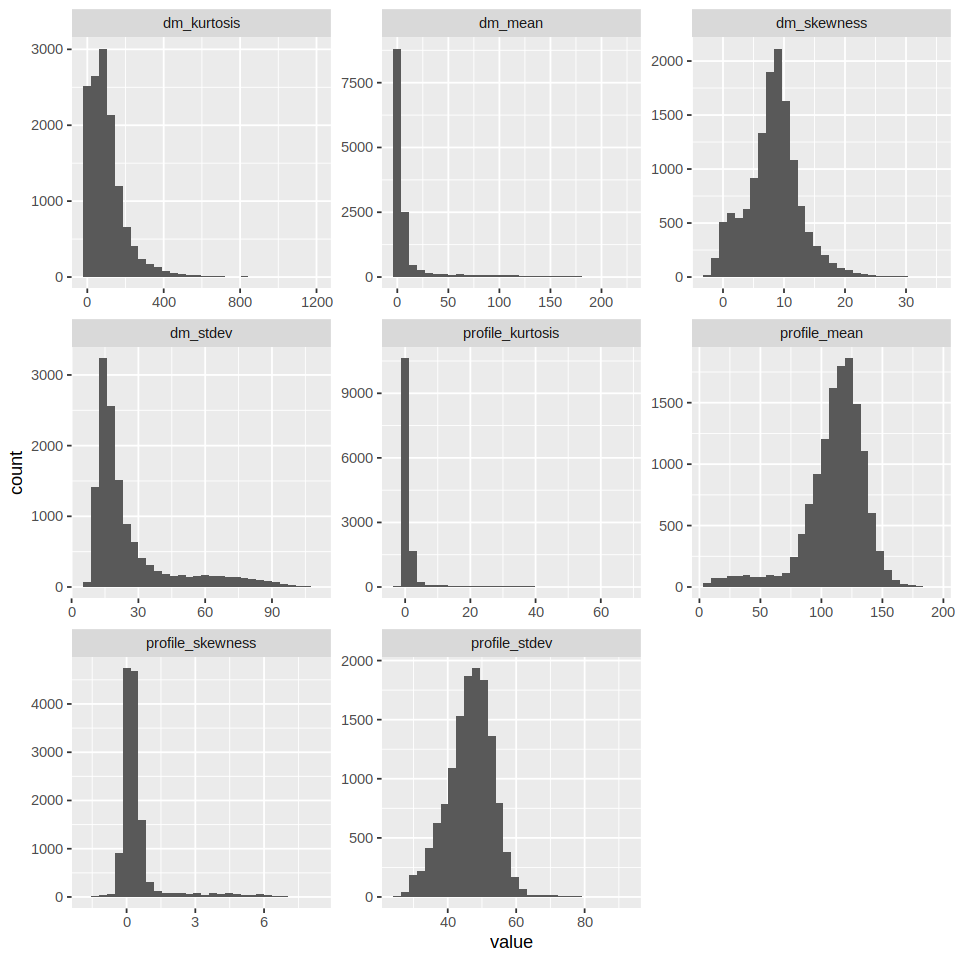

In [6]:
# visualize the data
options(repr.plot.width = 8, repr.plot.height = 8)

long_data <- pulsar_train |>
    select(profile_mean:dm_kurtosis) |>
    gather(column_name, value)

# draw a histogram for each numeric variable
hist_plots <- ggplot(long_data, aes(x = value)) +
    geom_histogram() +
    facet_wrap(~ column_name, scales = "free")

hist_plots

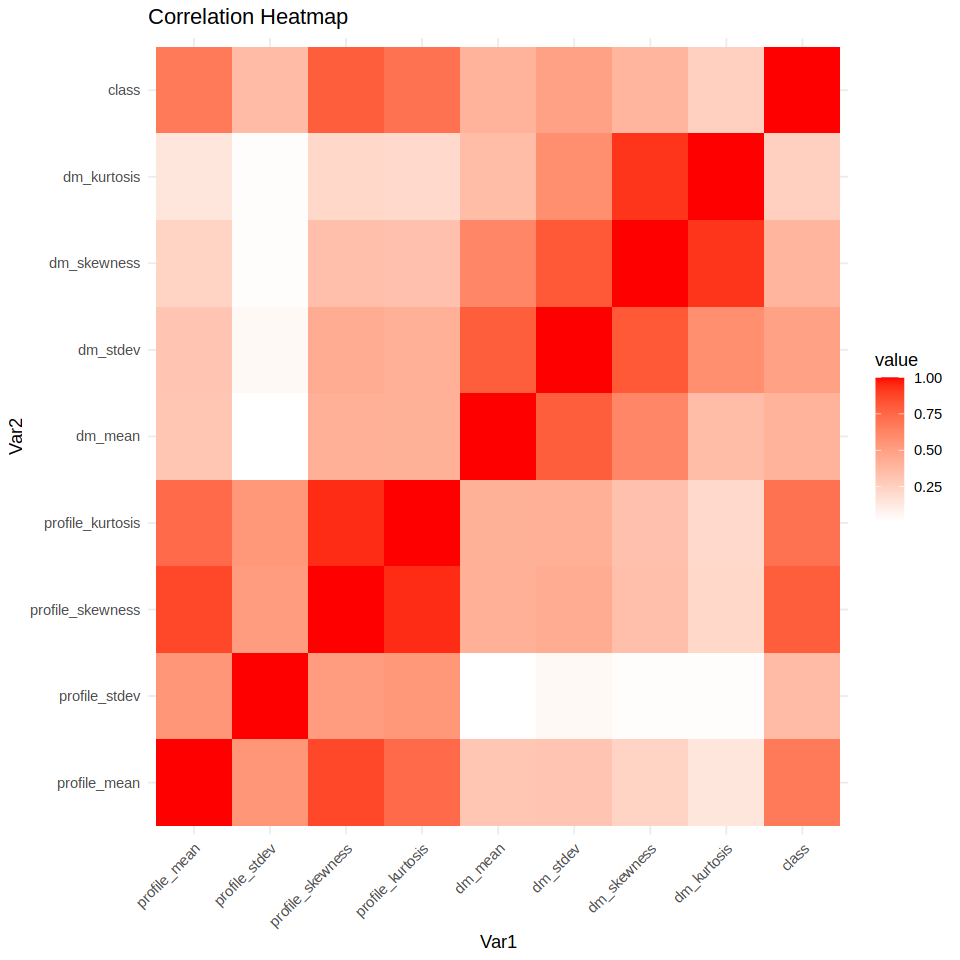

In [7]:
# draw correlation heatmap
options(repr.plot.width = 8, repr.plot.height = 8)

# create a correlation matrix
correlation_matrix <- pulsar_train |>
    mutate(class = as.numeric(class)) |>
    cor()

# change the matrix to dataframe and change values to absolute values
cor_df <- melt(correlation_matrix) |>
    mutate(value = abs(value))

ggplot(cor_df, aes(x = Var1, y = Var2, fill = value)) +
  geom_tile() +
  scale_fill_gradient(low = "white", high = "red") +
  labs(title = "Correlation Heatmap") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

According to the correlation heatmap above, profile_kurtosis, profile_skewness, and profile_mean have the largest absolute values of correlation with the target class. Therefore, we will be using these variables as predictors in our model.

## Data Analysis

We will use the K-nearest neighbors algorithm to train a model to answer our predictive question.

### Creating a data preprocessing recipe

In [8]:
pulsar_recipe <- recipe(class ~ profile_kurtosis + profile_skewness + profile_mean, data = pulsar_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

pulsar_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [9]:
pulsar_vfold <- vfold_cv(pulsar_train, v = 5, strata = class)

k_values <- tibble(neighbors = seq(from = 1, to = 50, by = 5))

knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

In [10]:
tuning_metrics <- workflow() |>
    add_recipe(pulsar_recipe) |>
    add_model(knn_spec_tune) |>
    tune_grid(resamples = pulsar_vfold, grid = k_values) |>
    collect_metrics()

tuning_accuracies <- tuning_metrics |>
    filter(.metric == "accuracy")

tuning_accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9650601,5,0.0008435235,Preprocessor1_Model01
6,accuracy,binary,0.9781719,5,0.0015379182,Preprocessor1_Model02
11,accuracy,binary,0.9782464,5,0.0014255390,Preprocessor1_Model03
16,accuracy,binary,0.9783955,5,0.0013828856,Preprocessor1_Model04
21,accuracy,binary,0.9780974,5,0.0013699906,Preprocessor1_Model05
26,accuracy,binary,0.9782463,5,0.0013197287,Preprocessor1_Model06
31,accuracy,binary,0.9782464,5,0.0014828539,Preprocessor1_Model07
36,accuracy,binary,0.9779483,5,0.0016292682,Preprocessor1_Model08
41,accuracy,binary,0.9777248,5,0.0014728424,Preprocessor1_Model09


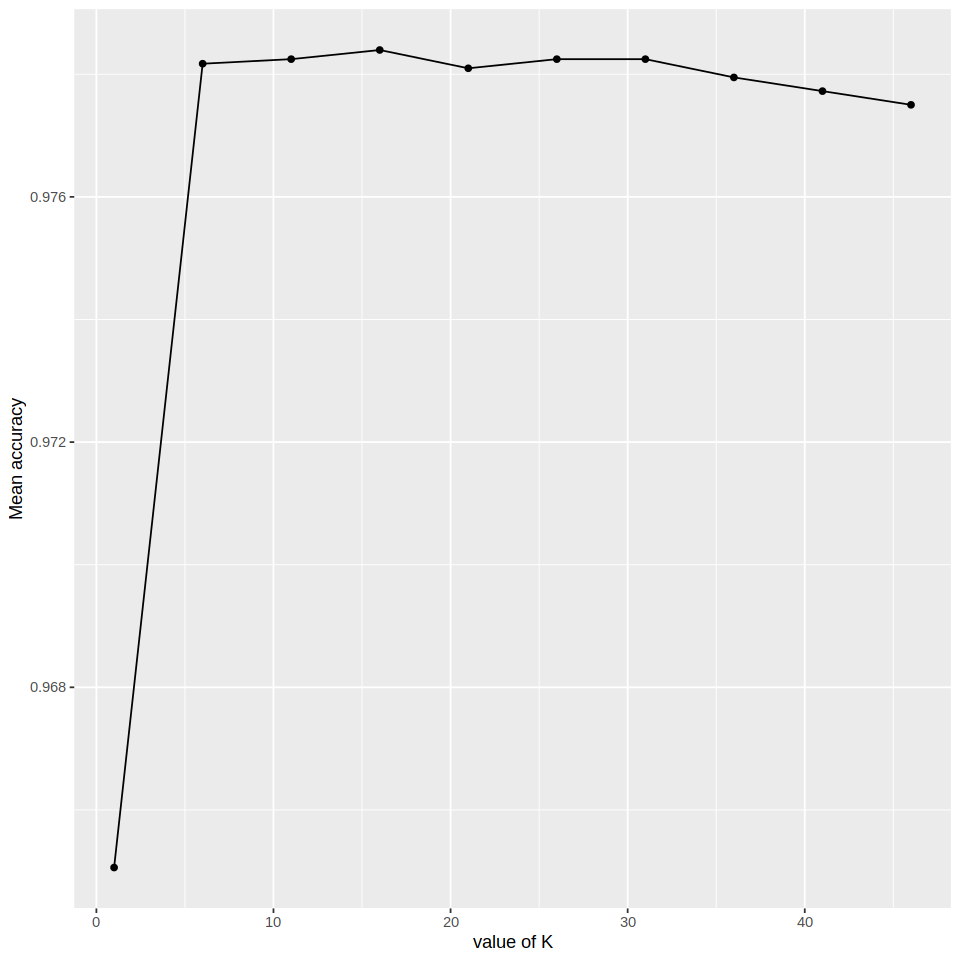

In [11]:
knn_plot <- ggplot(tuning_accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    xlab("value of K") +
    ylab("Mean accuracy")

knn_plot

In [12]:
optimal_k <- slice_max(tuning_accuracies, mean, n = 1) |>
    select(neighbors) |>
    pull()

optimal_k

[1] 16

In [13]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = optimal_k) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(pulsar_recipe) |>
    add_model(knn_spec) |>
    fit(data = pulsar_train)

In [14]:
pulsar_predictions <- knn_fit |>
    predict(pulsar_test) |>
    bind_cols(pulsar_test)

pulsar_metrics <- pulsar_predictions |>
    metrics(truth = class, estimate = .pred_class) |>
    filter(.metric == "accuracy")

pulsar_conf_mat <- pulsar_predictions |>
    conf_mat(truth = class, estimate = .pred_class)

pulsar_metrics
pulsar_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9798883


          Truth
Prediction    0    1
         0 4036   62
         1   28  349

## Methods

We are seeking to answer a classification question. We will use the K-nearest neighbors algorithm and use cross validation to find the an optimal value of K. Furthermore, we will standardize the data. Since the number of observations from the classes are not balanced, we will use up-sampling to balance the data. As explained, we will be using profile_kurtosis, profile_skewness, and profile_mean as predictor variables for our model as these variables have the highest absolute values of correlation with the target class.

In the end, we will compute accuracy for our model and show the confusion matrix to calculate precision and recall as well. We will visualize the results by drawing a line plot of model accuracy for different values of K.

## Expected outcomes and significance

In the end, we expect to have a model that can predict pulsar emissions from radio noise with reasonable accuracy. As pulsars are of considerable scientific interest in astronomy, this will help scientists working in this area.

One other question and challenge that this can lead to is to predict multi-class labels for signals to detect different types of pulsars. This can be achieved using a multi-class dataset and by training a multi-class classifier in the future.